# DATA ANALYSIS COUNT

In [205]:
from gensim.models import word2vec
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import umap
import pacmap
import numpy as np
import re
import json
import csv
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize



In [206]:
# model=word2vec.Word2Vec.load('../Data/Models/word2vec_epoch_1000_min_1.model')
#model=word2vec.Word2Vec.load('../Data/Models/best_model.model')
model=word2vec.Word2Vec.load('../Data/Models/best_model_new.model') #dim 300 mange gange med adressesammensmeltning
#model=word2vec.Word2Vec.load('../Data/Models/best_model_100_dim_5e.model')

In [207]:
f = open('../Data/data.json')
data = json.load(f)

a = open('../Data/added_data.json')
added_data = json.load(a)

In [208]:
with open('../Data/sequences.csv', 'r') as f:
    reader = csv.reader(f)
    sequences = list(reader)

In [209]:
X = model.wv.vectors

In [231]:
# tsne
def tsne_plot(X):
    X=np.array(X)
    #pca = PCA(n_components=50)
    #X_pca=pca.fit_transform(X)
    proj = TSNE(perplexity=20).fit_transform(X)
    return proj
proj=tsne_plot(X)

# UMAP 
proj_1 = umap.UMAP(n_components=2, n_neighbors=20, metric='cosine').fit_transform(X)

# pca 
pca = PCA(n_components=2)
proj_2=pca.fit_transform(X)

In [240]:
# pacmap 
embedding = pacmap.PaCMAP(n_components=2, n_neighbors=15, MN_ratio=0.5, FP_ratio=2.0) 
proj_3 = embedding.fit_transform(X, init="pca")


In [212]:
# Create a dictionary to map addresses to their corresponding embeddings
journey_embeddings = {}
for journey in sequences:
    for place in journey:
        try:
            journey_id = place  # Convert the journey list to a tuple to use as a dictionary key
            journey_embeddings[journey_id] = model.wv[journey_id]
        except KeyError:
            # Handle cases where the journey is not present in the Word2Vec model
            pass

# Convert dictionary to numpy array
X = np.array(list(journey_embeddings.values()))

# Create a list of all addresses
journey_ids = list(journey_embeddings.keys())

# Create a dictionary mapping addresses to their index in the numpy array
journey_idx = {journey_id: idx for idx, journey_id in enumerate(journey_ids)}

In [213]:
print(len(journey_ids)) #number of unique locations is 3751

3751



____________________________________________________________________________________________________________________________________________________



















# Cosine similarity

In [214]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# Assuming X is your embeddings_matrix
embeddings_matrix = X.shape

# Calculate cosine similarity matrix between station vectors
similarity_matrix = cosine_similarity(X)

highest = -1
for i in range(similarity_matrix.shape[0]):
    for j in range(similarity_matrix.shape[1]):
        if i != j and similarity_matrix[i, j] > highest:
            highest = similarity_matrix[i, j]

print(highest)

# Find the indices of the maximum similarity score in the updated matrix
max_indices = np.argwhere(similarity_matrix == highest)

# Extract the indices of the most similar pair
most_similar_pair_indices = max_indices[0]

# Get the station names corresponding to the indices
station_names = model.wv.index_to_key
station_i_name = station_names[most_similar_pair_indices[0]]
station_j_name = station_names[most_similar_pair_indices[1]]

# Print the names of the two most similar stations
print(f"The two most similar stations (not the same) are: {station_i_name} and {station_j_name}")

# # X is your numpy array containing the embedding vectors. Each row of X represents a vector in the embedding space.
# # cosine_similarity(X) computes the cosine similarity between all pairs of vectors in X.
# # The resulting similarity_matrix is a symmetric matrix where each element similarity_matrix[i, j] represents the cosine similarity between vectors X[i] and X[j].
# # After calculating the cosine similarity matrix, you can proceed to perform clustering or any other analysis based on the similarity values.

0.99548227
The two most similar stations (not the same) are: C.M. Larsens Alle and Syrefabriksvej


In [215]:
for seq in sequences:
    if 'Syrefabriksvej' in seq:
        print(seq)

print()

for seq in sequences:
    if 'C.M. Larsens Alle' in seq:
        print(seq)

['Grækenlandsvej', 'Syrefabriksvej']
['Fjelstrupvej', 'Syrefabriksvej']
['Syrefabriksvej', 'Jemtelandsgade']
['Syrefabriksvej', 'Jemtelandsgade']
['Grækenlandsvej', 'Syrefabriksvej']
['Fjelstrupvej', 'Syrefabriksvej']
['Italiensvej', 'Syrefabriksvej']
['Refshaleøen', 'Syrefabriksvej']
['Børsen', 'Syrefabriksvej']
['Skottegården', 'Syrefabriksvej']
['Florensvej', 'Syrefabriksvej']
['Børsen', 'Syrefabriksvej']

['C.M. Larsens Alle', 'Nørreport St.']
['C.M. Larsens Alle', 'Colbjørnsensgade']
['C.M. Larsens Alle', 'Refshaleøen']
['C.M. Larsens Alle', 'Nørreport St.']
['C.M. Larsens Alle', 'Refshaleøen']
['Ørestad St.', 'C.M. Larsens Alle']
['C.M. Larsens Alle', 'København H']
['C.M. Larsens Alle', 'Nørreport St.']
['C.M. Larsens Alle', 'Backersvej']
['C.M. Larsens Alle', 'Kongens Nytorv St. (Metro)']
['C.M. Larsens Alle', 'Sydhavn St.']
['C.M. Larsens Alle', 'Refshaleøen']
['C.M. Larsens Alle', 'Kongens Nytorv St. (Metro)']
['C.M. Larsens Alle', 'Kongens Nytorv St. (Metro)']
['C.M. Larsens

In [216]:
def find_similar(test): 
    similar_locations = model.wv.most_similar(test, topn=4000)
    similarity_map = {}  # Dictionary to store address-similarity pairs
    for address, similarity_score in similar_locations: 
        similarity_map[address] = similarity_score
    return similarity_map

### København H

In [217]:
from collections import Counter

# Initialize a Counter object to count station occurrences
station_counter = Counter()

# Iterate over sequences and count stations that appear together with 'København H'
for seq in sequences:
    if 'København H' in seq:
        for station in seq:
            # Skip 'København H' itself
            if station != 'København H':
                station_counter[station] += 1

# Print the station counts
for station, count in sorted(station_counter.items()):
    print(f"{station}: {count}")

A N Hansens Alle: 1
A&O Copenhagen Sydhavn: 2
A+O Copenhagen Sydhavn: 19
A. P. Møllers Allé: 98
A.C. Meyers Vænge: 194
A.D. Jørgensens Vej: 5
A.D. Jørgensens vej: 7
A.F. Beyers Vej: 8
A.H. Vedels Plads: 2
A.L. Drewsens Vej: 8
A.N. Hansens Allé: 3
A.P. Møllers Allé: 16
AC Hotel Bella Sky Copenhagen: 105
Aalborg Universitet København: 7
Aarestrupsvej: 2
Aberdeengade: 14
Abildvang: 1
Absalonsgade: 1
Adelgade: 128
Adilsvej: 8
Adina Apartment Hotel: 5
Adriansvej: 1
Agerlandsvej: 3
Aggersvoldvej: 11
Agnes Henningsens Vej: 1
Agnetevej: 1
Ahlefeldtsgade: 2
Ahlmanns Alle: 3
Ahornsgade: 48
Ahornskellet: 2
Ahrenkildes Allé: 15
Aksel Møllers Have: 22
Aksel Møllers Have St.: 197
Aksel Møllers Have St. (Metro): 2225
Aktivitetscenteret: 1
Albaniensgade: 1
Albert Schweitzers Vej: 1
Aldersrogade: 6
Alexandriagade: 189
Alhambravej: 8
Alkmaar Alle: 1
Alkmaar Allé: 30
Alleen: 29
Allegade: 18
Allersgade: 5
Alliancevej: 5485
Alperosevej: 2
Alrunevej: 1
Alstedvej: 8
Amager Bakke: 4
Amager Bio: 3
Amager Boule

# Validation of embeddingspace
The paper validates the emdeddingspace shown by doing some similarity tests

In [218]:
find_similar('København H')

{'København H (Metro)': 0.4125281572341919,
 'Rådhuspladsen': 0.37930673360824585,
 'Rådhuspladsen St.': 0.35797086358070374,
 'Bernstorffsgade': 0.3288237452507019,
 'Vesterport St.': 0.32287493348121643,
 'Glyptoteket': 0.31820034980773926,
 'Polititorvet': 0.2834121882915497,
 'Planetariet': 0.2793344557285309,
 'Vesterbrogade': 0.2737449109554291,
 'Davids Samling': 0.2718374729156494,
 'Nørreport St.': 0.26450857520103455,
 'Trommesalen': 0.25696951150894165,
 'Niels W. Gades Gade': 0.2526005208492279,
 'Banegårdspladsen': 0.25159400701522827,
 'Vesterbros Torv': 0.2513546645641327,
 'Reventlowsgade': 0.23936989903450012,
 'Nimb': 0.23706625401973724,
 'Rådhuspladsen St. (Metro)': 0.23637980222702026,
 'Tivolislottet': 0.23365958034992218,
 'Station Vesterbro': 0.2324676513671875,
 'Charlotte Ammundsens Plads': 0.23205862939357758,
 'Hvalsø': 0.2297143042087555,
 'Richmond Hotel': 0.2293800264596939,
 'Axeltorv': 0.22702018916606903,
 'Cirkusbygningen': 0.22679628431797028,
 'Stor

In [219]:
find_similar('CPH Lufthavn')

{'Kastrup Tværvej B': 0.3608551621437073,
 'Clarion Hotel Copenhagen Airport': 0.3446331322193146,
 'Terminalvej Airside': 0.32962140440940857,
 'Kastrup St. (Metro)': 0.3076775372028351,
 'Vestvej': 0.3003396987915039,
 'Kastrup Tværvej F': 0.29943904280662537,
 'Ellehammersvej': 0.296190083026886,
 'Lufthavnstorvet': 0.2934845983982086,
 'Københavns Lufthavn': 0.29071947932243347,
 'Terminalgade': 0.29054927825927734,
 'Kastrup Tværvej C': 0.2898296117782593,
 'Cirklen': 0.28196683526039124,
 'Fingervej A-Øst': 0.2817593514919281,
 'Kastrup Lystbådehavn': 0.2782544195652008,
 'Tårnby/Dragør': 0.2775867283344269,
 'Kastrup Tværvej D': 0.2698283791542053,
 'Fredens Bro': 0.26541849970817566,
 'Københavns Lufthavn St. (Metro)': 0.25992169976234436,
 'Kastrup Tværvej E': 0.25928837060928345,
 'København Kastrup': 0.256918340921402,
 'Stærevænget': 0.2565392851829529,
 'Sindingvej': 0.25532984733581543,
 'Lufthavnen St. (Metro)': 0.25487780570983887,
 'Københavns Lufthavn Kastrup Terminal

In [220]:
find_similar('Syrefabriksvej')

{'Lærkeskellet': 0.40716251730918884,
 'Københavns Museum': 0.3925866186618805,
 'Floras Allé': 0.38610130548477173,
 'Haveforeningen Uganda': 0.3832564353942871,
 'Pelargonievej': 0.34898698329925537,
 'Vamdrupvej': 0.34372732043266296,
 'Granatvej': 0.34253162145614624,
 'Stavlundvej': 0.3381940722465515,
 'Slagelse St.': 0.322038859128952,
 'Kornerupvej': 0.32150739431381226,
 'Sankt Peders Vej': 0.3208520710468292,
 'Tunet': 0.3196386694908142,
 'Zinniavej': 0.31784772872924805,
 'H.C. Ørsted Gymnasiet': 0.31390711665153503,
 'Under Krystallen': 0.3133665919303894,
 'Krøyers Plads': 0.3116530776023865,
 'Dragør Museum': 0.31093156337738037,
 'Sudanvej': 0.30918291211128235,
 'Langelinie Mole Midt': 0.3055591583251953,
 'Viemosevej': 0.3039243817329407,
 'Nationalmuseet': 0.3001278340816498,
 'Hf. Engly': 0.2997381389141083,
 'Valby Torvegade': 0.29735836386680603,
 'Thyvej': 0.2945437729358673,
 'Kålagervej': 0.2921633720397949,
 'Dahlerupsgade': 0.29141107201576233,
 'Hans Olriks 

In [221]:
find_similar('C.M. Larsens Alle')

{'Hovedstien': 0.36606401205062866,
 'Ulspilsager': 0.36487913131713867,
 'Ridefogedvej': 0.35542985796928406,
 'Hattensens Alle': 0.35270437598228455,
 'Arveprinsensvej': 0.35073748230934143,
 'Broagergade': 0.34962645173072815,
 'Børnehusbroen': 0.34853658080101013,
 'Borgskrivervej': 0.34199491143226624,
 'Mercur Hotel': 0.3254954516887665,
 'Trøjborggade': 0.32223859429359436,
 'Vestbirk Alle': 0.31736427545547485,
 'Bertel Thorvaldsens Plads': 0.31675413250923157,
 'H.C. Ørsted Institutet': 0.3158392310142517,
 'Trondhjemsgade': 0.3135645091533661,
 'Slotsherrens Have': 0.31352782249450684,
 'Krøyers Plads': 0.31331971287727356,
 'Asnæsgade': 0.31197190284729004,
 'Nordhavn': 0.31132325530052185,
 'Onsbjerg Allé': 0.3105435371398926,
 'Nordre Digevej': 0.3103382885456085,
 'Hotel Euroglobe': 0.309048593044281,
 'Blekingegade': 0.30659204721450806,
 'Fælledparken': 0.30576789379119873,
 'Teglbrændervej': 0.30348291993141174,
 'Dybensgade': 0.3034135699272156,
 'Brofogedvej': 0.3006

#### København H validation on cosine embedding

In [248]:
kbh_index = journey_idx['København H']

similarity_scores_with_kbh = similarity_matrix[kbh_index]

# Create a map of addresses to similarity scores with 'CPH Lufthavn'
addresses_similarity_map_kbh = {}
for i, score in enumerate(similarity_scores_with_kbh):
    address = journey_ids[i]
    addresses_similarity_map_kbh[address] = score

sorted_addresses_similarity_kbh = dict(sorted(addresses_similarity_map_kbh.items(), key=lambda item: item[1], reverse=False))


low Den Ukrainske Ambassade    -0.18857929
high København H    1.0000002


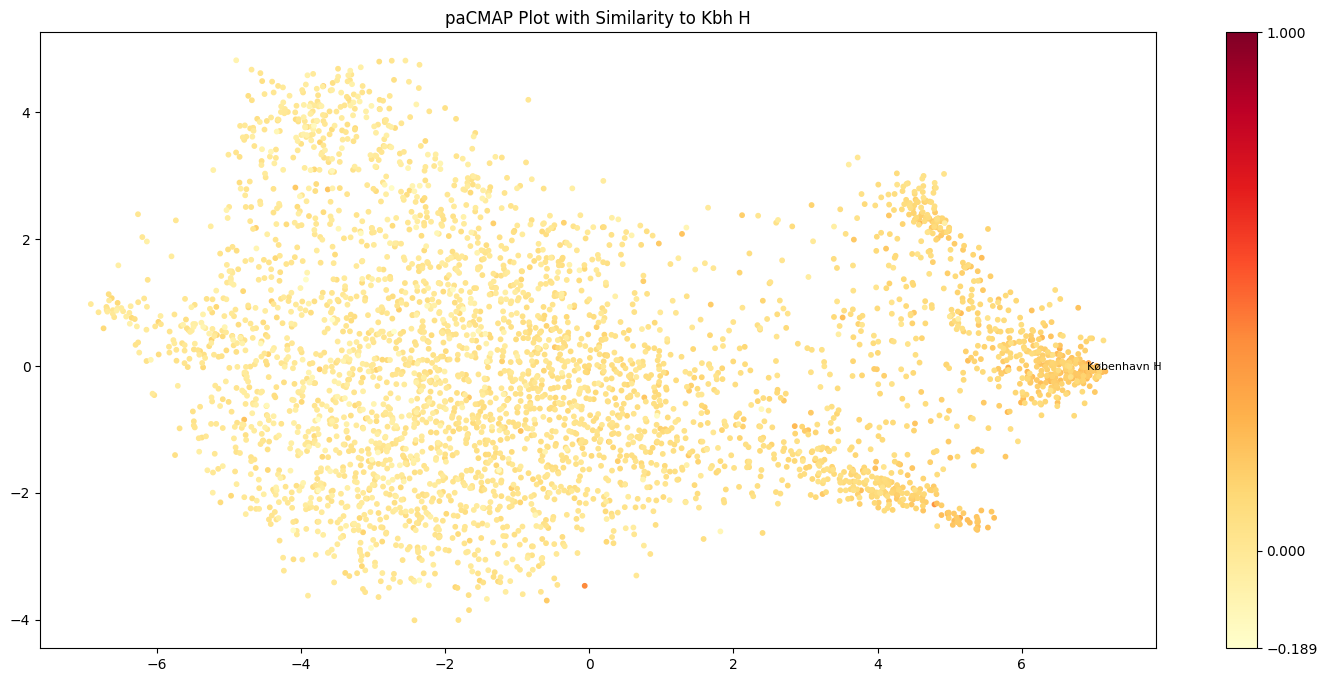

In [249]:

station_names = sorted_addresses_similarity_kbh.keys()
# Get the first element
low_key, low_value = next(iter(sorted_addresses_similarity_kbh.items()))
high_key, high_value = list(sorted_addresses_similarity_kbh.items())[-1]

print("low", low_key, "  ", low_value)
print("high", high_key, "  ", high_value)
norm = Normalize(vmin=low_value, vmax=high_value)
fig, ax = plt.subplots(1, 1, figsize=(18, 8))

grayscale_values = [(sorted_addresses_similarity_kbh[station]) for station in station_names]
grayscale_values.reverse()
# Plot the stations using paCMAP with grayscale colors
scatter = plt.scatter(proj_3[:, 0], proj_3[:, 1], c=grayscale_values, cmap='YlOrRd', s=10, alpha=1.0)

# Set the colorbar
colorbar = plt.colorbar(scatter, ax=ax)

# Manually set colorbar ticks and labels
colorbar.set_ticks([high_value, 0, low_value])  # Adjust these as needed based on your scale

#ADD LABELS TO TOP "="
# reversed_sim_kbh = dict(sorted(addresses_similarity_map_kbh.items(), key=lambda item: item[1], reverse=True))
# top_20_keys = list(reversed_sim_kbh.keys())
# top_20_kbh_sim = list(islice(top_20_keys, 20))
# print(top_20_kbh_sim)

# for location in top_20_kbh_sim:
#     idx = journey_idx[location]
#     plt.text(proj_3[idx,0], proj_3[idx,1], location, fontsize=8, ha='left')

#ADD LABEL TO JUST KØBENHAVN H
plt.text(proj_3[kbh_index, 0], proj_3[kbh_index, 1], 'København H', fontsize=8, ha='left')

plt.title('paCMAP Plot with Similarity to Kbh H')
plt.show()


#### Vanløse St. validation on cosine embedding

In [243]:

vanløse_index = journey_idx['Vanløse St.']
similarity_scores_vanløse = similarity_matrix[vanløse_index]

# Create a map of addresses to similarity scores with 'CPH Lufthavn'
addresses_similarity_map_vanløse = {}
for i, score in enumerate(similarity_scores_vanløse):
    address = journey_ids[i]
    addresses_similarity_map_vanløse[address] = score

sorted_addresses_similarity_vanløse = dict(sorted(addresses_similarity_map_vanløse.items(), key=lambda item: item[1], reverse=False))

# # Print the similarity scores of all addresses with 'CPH Lufthavn'
# for address, similarity_score in sorted_addresses_similarity_vanløse.items():
#     print(f"Similarity score between 'Vanløse' and '{address}': {similarity_score}")

low Jadegangen    -0.07909552
high Vanløse St.    1.0


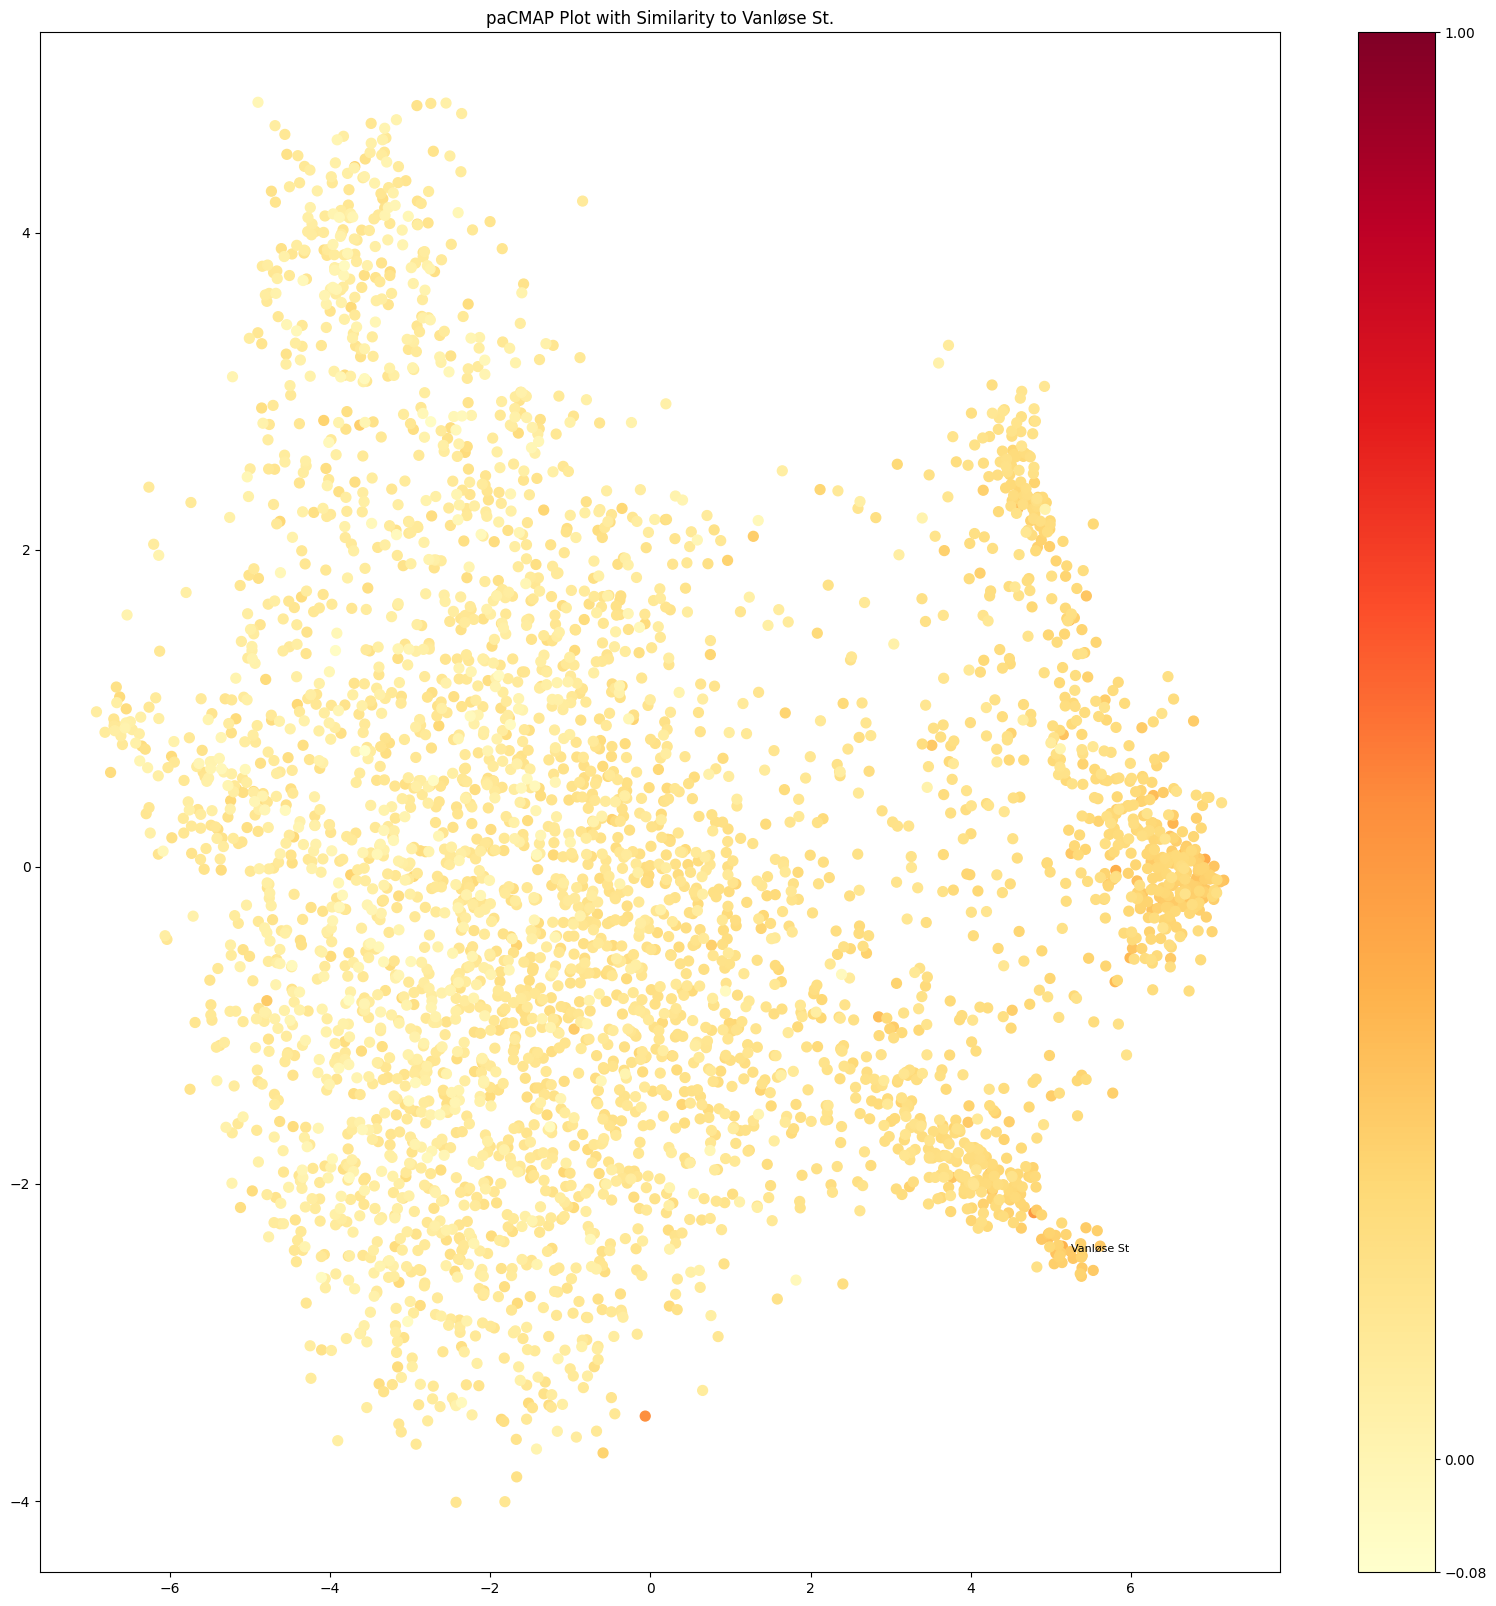

In [247]:
station_names_v = sorted_addresses_similarity_vanløse.keys()
# Get the first element
low_key_v, low_value_v = next(iter(sorted_addresses_similarity_vanløse.items()))
high_key_v, high_value_v = list(sorted_addresses_similarity_vanløse.items())[-1]

print("low", low_key_v, "  ", low_value_v)
print("high", high_key_v, "  ", high_value_v)
norm_v = Normalize(vmin=low_value_v, vmax=high_value_v)
fig_v, ax_v = plt.subplots(1, 1, figsize=(20, 20))

grayscale_values_v = [(sorted_addresses_similarity_vanløse[station]) for station in station_names_v]
grayscale_values_v.reverse()
# Plot the stations using paCMAP with grayscale colors
scatter_v = plt.scatter(proj_3[:, 0], proj_3[:, 1], c=grayscale_values_v, cmap='YlOrRd', s=50, alpha=1.0)

# Set the colorbar
colorbar_v = plt.colorbar(scatter_v, ax=ax_v)

# Manually set colorbar ticks and labels
colorbar_v.set_ticks([high_value_v, 0, low_value_v])  # Adjust these as needed based on your scale

# ADD LABEL TO JUST VANLØSE ST
plt.text(proj_3[vanløse_index, 0], proj_3[vanløse_index, 1], 'Vanløse St', fontsize=8, ha='left')

plt.title('paCMAP Plot with Similarity to Vanløse St.')
plt.show()
